# Workshop NLP: classificação de textos utilizando K-Nearest Neighbors com base na similaridade de cossenos 

Importando bibliotecas necessárias:

In [36]:
import random
import numpy as np
import pandas as pd
import copy 
import re
import matplotlib.pyplot as plt

import time

import seaborn as sns

from sklearn.model_selection import train_test_split

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

Lendo base de dados com avaliação dos filmes (a base de dados pode ser baixada em https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews):

In [37]:
data=pd.read_csv("imdb-dataset-of-50k-movie-reviews/IMDB_Dataset.csv")

Visualizando base de dados:

In [38]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Vamos converter a nossa variável de interesse ('sentiment') em uma variável dummy binária:

In [39]:
data['positive']=pd.get_dummies(data['sentiment'])['positive']

Observando os dados novamente:

In [40]:
data.head()

,review,sentiment,positive
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


Vamos transformar nossa base de dados em duas listas (uma para os textos e outra para a variável de interesse):

In [41]:
X=data['review'].to_list()
y=data['positive'].to_list()

Checando um texto da lista:

In [42]:
X[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

Checando sua classe:

In [43]:
y[1]

1

Definindo uma função para a limpeza dos textos:

In [44]:
def clean(resulta):   
    result = copy.deepcopy(resulta)
    
    result=result.lower()
    result=result.replace("<br />","")
    result=re.sub('\d', ' ', result)
    result=result.replace("\n", " ")
    result=result.replace("/", "")
    result=result.replace("|", "")
    result=result.replace("+", "")
    result=result.replace(".", "")
    result=result.replace(",", "")
    result=result.replace(":", "")
    result=result.replace(";", "")
    result=result.replace("!", "")
    result=result.replace("?", "")
    result=result.replace(">", "")
    result=result.replace("=", "")
    result=result.replace("§", "")
    result=result.replace(" - ", " ")
    result=result.replace(" _ ", " ")
    result=result.replace("&", "")
    result=result.replace("*", "")
    result=result.replace("(", "")
    result=result.replace(")", "")
    result=result.replace("ª", "")
    result=result.replace("º", "")
    result=result.replace("%", "")
    result=result.replace("[", "")
    result=result.replace("]", "")
    result=result.replace("{", "")
    result=result.replace("}", "")
    result=result.replace("'", "")
    result=result.replace('"', "")
    result=result.replace("“", "")
    result=result.replace("”", "")
    result=re.sub(' +', ' ', result)
    
    return(result)

Limpando cada um dos textos:

In [45]:
for i in range(len(X)):
    X[i]=clean(X[i])

Checando o mesmo texto de forma limpa:

In [46]:
X[1]

'a wonderful little production the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen- michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done'

Vamos dividir nossa base em bases de treino teste e validação:

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Tokenizando os textos na base de treino:

In [48]:
for i in range(len(X_train)):
    X_train[i]=X_train[i].split(' ')

## Doc2Vec

Vamos fazer uma breve introdução ao modelo **Doc2Vec** para a a geração de representações de textos (embeddings) de uma forma fácil e rápida. O modelo **Doc2Vec** é do ano de 2014 e foi descrito pela primeira por pesquisadores do Google no artigo [1] - as imagens utilizadas a seguir foram retiradas deste artigo. Um tutorial bem didático de como a técnica funciona pode ser acessado no link [2] e a documentação do método está em [3]. Antes de explicar como é o funcionamento do modelo **Doc2Vec** é necessário entender como o modelo **Word2Vec**, para o cálculo de representações para palavras, funciona. O modelo **Word2Vec** é um modelo que gera representações vetoriais para palavras de acordo com os contextos em que as palavras aparecem nos textos da nossa base de dados. Dessa maneira é possível pensar que a palavra 'rei' está para 'homem' assim como 'rainha' está para 'mulher' como na figura abaixo:

![title](word2vec.png)

É impressionante ver o poder de uma técnica relativamente simples que é o **Word2Vec**. Existem basicamente duas versões de modelos para o **Word2Vec**, a COBW (Continuous Bag of Words) e Skip-Gram - aqui focaremos basicamente na primeira abordagem. A abordagem COBW considera que a posição das palavras podem ser preditas pelo contextos nas quais estão inseridas (palavras no entorno). Chamamos esse contexto de 'janela'. Todas as palavras do vocabulário começam ccom uma representação aleatória que o modelo melhora de acordo com o processo de aprendiagem ao tentar inferir a presença de palavras pelos contextos nos quais estão inseridas. Assim cada palavra adquire uma representação compatível com os contextos em que geralmente essa palavra aparece. Temos então o seguinte esquema para uma implementação do **Word2Vec** COBW:

![title](word2vec2.png)

Agora que entendemos um pouco melhor como funciona o modelo **Word2Vec**, podemos entender como é o funcionamento do **Doc2Vec**. O segundo modelo acaba sendo uma extensão do primeiro. Assim como o **Word2Vec**, o modelo **Doc2Vec** tem duas versões principais e aqui focaremos naquela análoga ao COBW, que se chama PV-DM (Distributed Memory version of Paragraph Vector). A ideia continua igual, no entanto adicionamos um vetor específico para cada um dos documentos afim de predizer as palavras daquele documento específico. Assim, parte da informação que não capturada pelas representações das palavras é aprendida pelas representações dos textos. Quando formos treinar o modelo **Doc2vec** basta fornecermos os parâmetros 'window' (para o tamanho da janela) e 'size' para o tamanho dos embeddings (representações dos textos).

![title](doc2vec.png)

Fontes:

1. https://cs.stanford.edu/~quocle/paragraph_vector.pdf
2. https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
3. https://radimrehurek.com/gensim/models/doc2vec.html

Especificando hiperparâmetros para treinar modelo Doc2Vec. Neste caso 'window' se refere à distância máxima (em número de palavras) entre as palavras a serem inferidas e aquelas consideradas de contexto.

In [49]:
size=60
window=10

Treinando modelo:

In [50]:
start_time = time.time()

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train)]
model = Doc2Vec(documents, vector_size=size, window=window, dm_mean=1)

print(round((time.time() - start_time)/60,2),"minutos")

0.99 minutos


Salvando modelo em disco:

In [51]:
model.save('doc2vec')

Definindo função que fará o embedding:

In [52]:
def emb(txt, model, normalize=True): 
    model.random.seed(42)
    x=model.infer_vector(txt, steps=20)
    
    if normalize: return(x)
    else: return(x)

Carregando modelo:

In [53]:
embed = Doc2Vec.load('doc2vec')  

Vamos checar um exemplo:

In [54]:
exemplo=X_test[2]
exemplo

'if you like his show you might be a little disappointed this movie has some very funny moments and the laughs are pretty constant but none are very memorable or as funny as the things on the show the beginning sequence is really really silly and funny and a great start yes borat does make a cameo appearanceif you are a fan then watch it if you dont know him or dont like him then dont bother '

Tokenizando:

In [55]:
exemplo=exemplo.split(' ')

Aplicando o embedding:

In [56]:
emb(exemplo, embed)

array([-0.19106789, -0.69806296, -0.45041594,  0.39730644,  0.7292162 ,
        0.1752393 , -0.07743925,  0.47473794, -0.6600979 ,  0.44638714,
        0.47932103,  0.23939644,  0.30662227,  0.01594139, -0.28682792,
        0.2505153 ,  0.24800695, -0.11578204, -0.0965772 ,  0.1862743 ,
       -0.3901997 , -0.15411462, -0.46736604,  0.06410377, -0.08080368,
        0.08848385, -0.18887122,  0.15012017,  0.03431866,  0.13912565,
       -0.20832346,  0.22123975,  0.30517954,  0.16565876,  0.4210236 ,
       -0.2449358 ,  0.30144566, -0.9066247 ,  0.11628879,  0.03889168,
        0.30056238,  0.56299764, -0.30950996, -0.25613806,  0.06913479,
        0.38123992,  0.58782494,  0.46381363,  0.02587281,  0.40051618,
        0.17312145, -0.2865817 , -0.48257592,  0.12123825, -0.5893265 ,
       -0.25341198,  0.2859275 , -0.3282868 ,  0.20770316,  0.43039113],
      dtype=float32)

# Similaridade entre textos/palavras

## Revisão de Álgebra Linear

A Álgebra Linear é uma área fundamental da matemática com uma importância tão grande quanto à do Cálculo. Os objetos de estudo da Álgebra Linear são os Espaços Vetoriais, Vetores, Matrizes, Transformações Lineares entre outras coisas. Mas qual a importância disso tudo para a análise de dados e *Machine Learning*? Grande parte dos modelos estatísticos e matemáticos que veremos daqui para frente usam os conceitos de Vetores e Matrizes em sua construção, sem falar que muitas vezes conhecê-los pode facilitar a vida um bocado. É importante salientar que o conteúdo que será exposto nesse capítulo tem caráter extremamente prático, então deixaremos as partes mais teóricas para os livros didáticos. Mesmo que já tenha cursado essa disciplina anteriormente, acompanhe o capítulo e faça os exercícios propostos. Se ainda sim não ficar satisfeito, acompanhe nossas sugestões de leitura. Vamos lá!

### Matrizes

Matrizes (para mais detalhes: https://en.wikipedia.org/wiki/Matrix_(mathematics)) são uma coleção (Em computação, essas coleções se chamam arrays.) de números em forma de "tabela":


\begin{equation}
  \begin{aligned}
      A=\begin{pmatrix}
      a_{11} &  a_{12}&  a_{13}& a_{14}\\ 
      a_{21} &  a_{22}&  a_{23}& a_{24}\\ 
      a_{31} &  a_{32}&  a_{33}& a_{34}
      \end{pmatrix}
   \end{aligned}
\end{equation}


A matriz $A$ tem ordem 3X4 (3 linhas e 4 colunas), logo dizemos que $A \in \mathbb{R}^{3x4}$. Um exemplo mais palpável de matriz $A$ seria;

\begin{equation}
  \begin{aligned}
      A=\begin{pmatrix}
      0 &  4&  1& 7\\ 
      9& 3 & 4 & 1\\ 
      6 & 3 &  1& 0
      \end{pmatrix}
   \end{aligned}
\end{equation}

### Vetores

Os vetores são objetos que são encontrados nos Espaços Vetorias (https://en.wikipedia.org/wiki/Vector_space), que são estruturas matemáticas - se você for curioso(a) vale a pena conferir, mas se não tiver paciência, não há grandes problemas. Para nossos fins, vamos assumir que o espaço no qual estaremos trabalhando é o $\mathbb{R}^n$, sendo que $n$ é um número Natural diferente de zero. Ou seja, os elementos que habitam o $\mathbb{R}^n$ são pontos, como os pares ordenados, mas com $n$ coordenadas. Devido a uma série de definições e resultados matemáticos (Base ortonormal, coordenadas e espaços isomorfos.) cada um desses pontos representa um objeto geométrico chamado Vetor (Mais tarde veremos os vetores na forma matricial.) e devido a esses resultados matemáticos já citados, trabalhar com os pontos no $\mathbb{R}^n$ é equivalente a trabalhar com os vetores diretamente. Então a partir de agora passaremos a chamar pontos da forma $\mathbf{x}=(x_1,x_2,...,x_n)$ de vetores. Além dessa forma, o vetor $\mathbf{x}$ também pode ser representado na forma matricial (A convenção é de adotar vetores coluna - com $n$ linhas e 1 coluna.):

\begin{equation}
  \begin{aligned}
      \mathbf{x}=\begin{pmatrix} x_1 
      \\ x_2
      \\ ...
      \\ x_n
     \end{pmatrix}
   \end{aligned}
\end{equation}

### Operações com matrizes e vetores

#### Adição e subtração

Quando queremos somar duas matrizes (incluindo vetores na forma matricial) basta somarmos elemento por elemento. Logo, se $A+B=C$, então $a_{ij}+b_{ij}=c_{ij}$. por outro lado, se $A-B=C$, então $a_{ij}-b_{ij}=c_{ij}$. Pela definição de adição e subtração, temos que as matrizes $A$ e $B$ devem ter a mesma ordem $n X m$.

#### Produto por um escalar

Quando queremos multiplicar matrizes (incluindo vetores na forma matricial) por um escalar $\alpha$, basta multiplicarmos todos os elementos da matriz pelo escalar. Ou seja, se $B=\alpha A$ então, $b_{ij}=\alpha a_{ij}$.

#### Multiplicação de duas matrizes

Quando queremos multiplicar uma matriz (incluindo vetores na forma matricial) por outra matriz temos que aplicar uma fórmula específica. Vamos supor que $A\in \mathrm{R}^{n X k}$ e $B\in \mathrm{R}^{k X m}$ então se $C=AB$, logo $c_{ij}=a_{i1}b_{1j}+a_{i2}b_{2j}+...+a_{ik}b_{kj}=\sum_{p=1}^{k} a_{ip}b_{pj}$. Da nossa definição seguem as seguintes conclusões: (i) o número de colunas da primeira matriz (A) deve ser igual ao número de linhas da segunda (B) e (ii) e matriz produto C tem o número de linhas da primeira e o número de colunas da segunda.

#### Produto elemento a elemento

Nesse caso necessitamos que as duas matrizes que estão sendo multiplicadas tenham a mesma ordem. Se $C=A \bigodot B$ então $c_{ij}=a_{ij}b_{ij}$.

#### Transposição

A transposição é uma operação que inverte as colunas e as linhas de uma matrix, ou seja, se $B=A^T$ é a transposta de $A$, então $b_{ij}=a_{ji}$.

#### Links externos

Para ver com mais detalhes como funcionam as operações com matrizes, basta acessar os seguintes links:
- https://www.georgebrown.ca/uploadedFiles/TLC/_documents/Basic%20Matrix%20Operations.pdf
- https://www.infoescola.com/matematica/operacoes-com-matrizes-1/
- https://en.wikipedia.org/wiki/Matrix_(mathematics)


### Matrizes especiais
1. Matriz simétrica: a matriz simétrica é aquela que satisfaz $A=A^T$. Deve ser quadrada, ou seja, o número de linhas deve ser igual ao número de colunas;
2.  Matriz identidade: a matriz identidade é tem zeros em todas suas entradas, exceto pela sua diagonal principal, que é composta exclusivamente por uns. Deve ser quadrada e é denotada pela letra "i" maiúscula - I. A matriz $I_n$, por exemplo, é uma matriz identidade de ordem $n X n$. Uma propriedade de I é que se $AI_m=I_nA=A$, para qualquer matriz $A\in \mathrm{R}^{n X m}$;
3. Matriz inversa: se $A^{-1}$ é a inversa de A, então $A^{-1}A=AA^{-1}=I$.
4. Matriz de co-ocorrência são matrizes quadradas, geralmente utilizadas em imagens, onde são utilizadas para o cálculo de descritores. Nessas matrizes são armazenadas os valores de níveis de cinza da imagem nos seguintes ângulos:  $0, 45, 90, 135$, os demais ângulos são calculados por simetria (http://iris.sel.eesc.usp.br/wvc/Anais_WVC2012/pdf/97967.pdf).
5. Matriz de covariância: são as matrizes que contém as variâncias das variáveis em sua diagonal e nos demais pontos da matriz possui a covariância de todas as combinações dos pares das variáveis. São caracterizadas por serem matrizes quadradas. Geralmente são empregadas em aplicações estatísticas. 

### Produto escalar e norma euclidiana (comprimento)

Se ambos $\mathbf{x}=\begin{pmatrix} x_1 & x_2  & ... & x_n \end{pmatrix}^T$ e $\mathbf{y}=\begin{pmatrix} y_1 & y_2  & ... & y_n \end{pmatrix}^T$ são elementos do conjunto $\mathrm{R}^{n}$ então o produto escalar, ou muitas vezes referenciado como produto interno ou *inner product*, desses dois vetores é definido como $\sum_{i=1}^{n}x_iy_i=\mathbf{x}^T\mathbf{y}$. A norma euclidiana também conhecida como "módulo" do vetor pode ser calculada com a seguinte fórmula $\left \| \mathbf{x} \right \|=\sqrt{x^2_1+x^2_2+...+x^2_n}=\sqrt{\sum_{i=1}^{n}x^2_i}=\sqrt{\mathbf{x}^T\mathbf{x}}$.


## Similaridade

No contexto de NLP é comum utilizarmos a similaridade de cossenos para compararmos dois textos. É importante recordar que em nosso contexto, cada um dos textos é tratado como um vetor com comprimento, direção e sentido. Um vetor será expresso aqui na forma de matrizes unidimensionais (Numpy arrays). Um vetor de tamanho $n$ é uma lista de valores em forma matricial da seguinte forma:

\begin{equation}
  \begin{aligned}
      \mathbf{x}=\begin{pmatrix} x_1 
      \\ x_2
      \\ ...
      \\ x_n
     \end{pmatrix}
   \end{aligned}
\end{equation}

Assumindo que outro vetor $\mathbf{y}$ tenha o mesmo tamanho de $\mathbf{x}$, o cosseno do ângulo ($\theta$) entre os vetores é calculado da seguinte forma:

\begin{equation}
  \begin{aligned}
      cos(\theta)=\frac{\sum_{i=1}^{n}x_iy_i }{\sqrt{\sum_{i=1}^{n}x_i^2}\sqrt{\sum_{i=1}^{n}y_i^2}}=
      \frac{\mathbf{x}^T\mathbf{y}}{\sqrt{\mathbf{x}^T\mathbf{x}}.\sqrt{\mathbf{y}^T\mathbf{y}}}=
      \frac{\mathbf{x}^T\mathbf{y}}{\left \| \mathbf{x} \right \|.\left \| \mathbf{y} \right \|}
   \end{aligned}
\end{equation}

Se o comprimento dos vetores $\mathbf{y}$ e $\mathbf{x}$ é um, então podemos reescrever o cosseno da seguinte forma:

\begin{equation}
  \begin{aligned}
      cos(\theta)=\sum_{i=1}^{n}x_iy_i=
      \mathbf{x}^T\mathbf{y}
   \end{aligned}
\end{equation}

Para normalizar um vetor $\mathbf{x}$ para que tenha comprimento 1, basta fazer a seguinte atualização:

\begin{equation}
  \begin{aligned}
      \mathbf{x}=\frac{\mathbf{x}}{\sqrt{\mathbf{x}^T\mathbf{x}}}
   \end{aligned}
\end{equation}

## Parte prática

Definindo função que calcula a similaridade entre dois vetores. A similaridade (cosseno) varia de -1 a 1 sendo que valores positivos tem sentido parecidos e valores negativos nos dão sentidos opostos:

In [57]:
def simil(x,y):
    return((x@y)/np.sqrt((x@x)*(y@y)))

Definindo dois vetores e os visualizando:

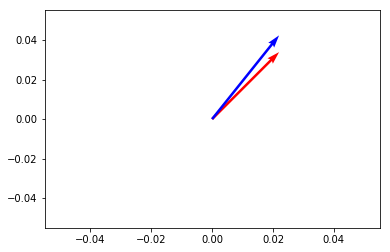

In [58]:
v1=np.array([2,2])
v2=np.array([2,2.5])

V = np.array([v1,v2])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=10)
plt.show()

Veja que o menor ângulo entre os vetores é pequeno então a similaridade deve dar algo próximo de 1:

In [59]:
simil(v1,v2)

0.9938837346736188

Veja que o cosseno entre os vetores não depende do tamanho dos vetores. Vamos manter o ângulo mas diminuindo o tamanho do vetor vermelho:

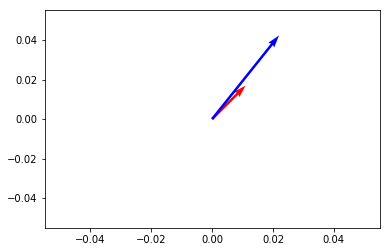

In [60]:
v1=np.array([1,1])
v2=np.array([2,2.5])

V = np.array([v1,v2])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=10)
plt.show()

Veja que a medida de similaridade não mudou:

In [61]:
simil(v1,v2)

0.9938837346736188

Se os vetores formam 90 graus entre si, temos que eles são ortogonais (não tem similaridade alguma entre si):

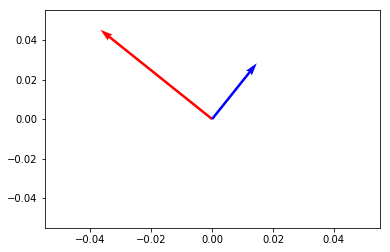

In [62]:
v1=np.array([-5,4])
v2=np.array([2,2.5])

V = np.array([v1,v2])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=15)
plt.show()

Calculando a similaridade:

In [63]:
simil(v1,v2)

0.0

Já se o menor ângulo entre os vetores é maior que 90 graus, ou seja, os vetores estão 'apontando' para sentidos opostos, a similaridade é negativa:

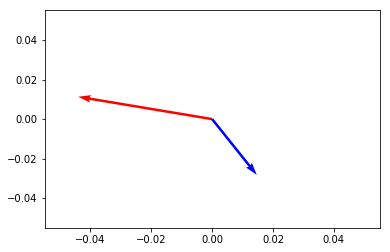

In [64]:
v1=np.array([-6,1])
v2=np.array([2,-2.5])

V = np.array([v1,v2])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=15)
plt.show()

Similaridade:

In [65]:
simil(v1,v2)

-0.7445694406464903

# TO DOs

- Deixar bases de treino, teste e validação em forma de matrizes (arrays bidimensionais) sendo que em cada linha devemos ter um texto 'embeddado' diferente e nas colunas devemos ter as dimnesões do embedding. Uma dica é mexer na função do embedding para que cada um dos vetores que representam um texto tenha comprimento 1, para facilitar no momento do cálculo das similaridades;

- Achar os $k$ textos mais próximos na base de treino para todos os textos da base de validação. Dica 1: utilizar multiplicação de matrizes. Dica 2: utilizar função 'argsort' do pacote Numpy:

- Determinar $k$ que maximiza a acurácia do modelo em fazer a classificação;

- Testar o modelo com melhor $k$ na base de teste e desenhar a matriz de confusão;